In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


2024-05-01 18:32:23.823927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:32:23.823977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:32:23.825896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 18:32:23.837129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 18:32:25.265980: W tensorflow/compiler/tf2

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-01 18:32:26.770148: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-01 18:32:26.770193: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: mostafa-Lenovo-ideapad-520-15IKB
2024-05-01 18:32:26.770202: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: mostafa-Lenovo-ideapad-520-15IKB
2024-05-01 18:32:26.770333: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.23.8
2024-05-01 18:32:26.770360: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.23.8
2024-05-01 18:32:26.770366: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.23.8


In [4]:
# Setup paths
POS_PATH = os.path.join('data-siames', 'positive')
NEG_PATH = os.path.join('data-siames', 'negative')
ANC_PATH = os.path.join('data-siames', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(NEG_PATH):
    for file in os.listdir(os.path.join(NEG_PATH, directory)):
        EX_PATH = os.path.join(NEG_PATH, directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [5]:
anchor = tf.data.Dataset.list_files("./"+ANC_PATH+'/*.jpg').take(300)

positive = tf.data.Dataset.list_files("./"+POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files("./"+NEG_PATH+'/*.jpg').take(300)


2024-04-23 22:05:43.345268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 22:05:43.345651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 22:05:43.345903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
len(positive)

In [4]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

Create Labele dataset

In [7]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [10]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [12]:
def make_embedding():
    inp = Input(shape=(100,100,3),name="input_image")

    #first conv
    c1 = Conv2D(64,(10,10),activation="relu")(inp)
    m1 = MaxPooling2D(64,(2,2),padding="same")(c1)

    #second
        # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

        # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
    


In [13]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [5]:
class L1Distance(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [15]:
def make_siamese_mode():
     # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [16]:
siamese_model = make_siamese_mode()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [20]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [21]:
def train(data, EPOCH):
    for epoch in range(1,EPOCH+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

             # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)
        

In [ ]:

EPOCHS = 50
train(train_data, EPOCHS)

In [ ]:
# Save weights
siamese_model.save('siamesemodel.keras')

In [6]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.keras', 
                            custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [8]:
model.save('saved_model/3')

INFO:tensorflow:Assets written to: saved_model/3/assets


INFO:tensorflow:Assets written to: saved_model/3/assets


In [7]:
def verify(model,detection_threshold, verfiy_threshold):
        # Build results array
    results = []
    for image in os.listdir(os.path.join('test-data', 'verification')):
        input_img = preprocess(os.path.join('test-data', 'input' , 'input_image.jpg'))
        validation_img = preprocess(os.path.join('test-data', 'verification', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        print(result)
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    print(len(os.listdir(os.path.join('test-data', 'verification'))))
    verification = detection / len(os.listdir(os.path.join('test-data', 'verification'))) 
    verified = verification > verfiy_threshold
    
    return results, verified
    

In [11]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [8]:
from PIL import Image

In [51]:
def face_detector(img_path):
    open_cv_image = cv2.imread(img_path)
    original = open_cv_image.copy()
    
    # rgb = pil_image.convert('RGB')
    # open_cv_image = np.array(rgb)
    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray)
    if len(faces) > 0:
        # Assuming the first face is the target, you can modify this based on your requirements
        x, y, w, h = faces[0]

        # Calculate the new coordinates and dimensions for a 1:1 aspect ratio
        center_x = x + w // 2
        center_y = y + h // 2
        size = int(max(w, h))
        x_new = max(0, center_x - size // 2)
        y_new = max(0, center_y - size // 2)

        # Crop the head region with a 1:1 aspect ratio
        cropped_head = original[y_new:y_new+size, x_new:x_new+size]
        plt.imshow(cv2.cvtColor(cropped_head, cv2.COLOR_BGR2RGB))
        
        #cv2.imwrite(img_path, cropped_head)
        # # Convert the cropped head back to PIL format
        cropped_head_pil = Image.fromarray(cv2.cvtColor(cropped_head, cv2.COLOR_BGR2RGB))
       
        # # Save the cropped head image
        cropped_head_pil.save(img_path)
        print("Cropped head saved successfully.")
    else:
        print("not valid face")
        
    return len(faces) > 0

Cropped head saved successfully.


True

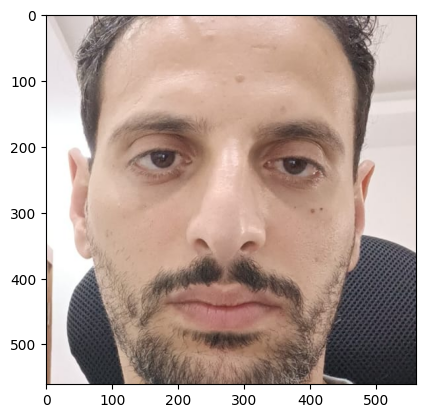

In [52]:
face_detector(os.path.join('test-data', 'input', 'input_image.jpg'))


In [27]:
for image in os.listdir(os.path.join('test-data', 'verification')):
    face_detector(os.path.join('test-data', 'verification', image))


Cropped head saved successfully.


In [8]:
results, verified = verify(model, 0.5, 0.5)
print(verified)

1/1 [==============================] - 0s 298ms/step
[[0.50431234]]
1
True


In [26]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('test-data', 'input', 'input_image.jpg'), frame)
        face_detector(os.path.join('test-data', 'input', 'input_image.jpg'))
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

not valid face
1/1 [==============================] - 0s 18ms/step
[[0.17169562]]
1
False
Cropped head saved successfully.
1/1 [==============================] - 0s 18ms/step
[[0.00021518]]
1
False
